# Building our first neural network in tensorflow

In this tutorial part we will build a deep neural network using tensorflow. 

- Create the computation graph
- Run the graph

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

In [3]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prepare_data(images):
    m = len(images)
    X = np.zeros((m, ROWS, COLS, CHANNELS), dtype=np.uint8)
    y = np.zeros((1, m), dtype=np.uint8)
    for i, image_file in enumerate(images):
        X[i,:] = read_image(image_file)
        if 'dog' in image_file.lower():
            y[0, i] = 1
        elif 'cat' in image_file.lower():
            y[0, i] = 0
    return X, y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
TRAIN_DIR = 'Train_data/'
TEST_DIR = 'Test_data/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_set_x, train_set_y = prepare_data(train_images)
test_set_x, test_set_y = prepare_data(test_images)

train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], ROWS*COLS*CHANNELS).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

X_train = train_set_x_flatten/255
X_test = test_set_x_flatten/255

Y_train = convert_to_one_hot(train_set_y, CLASSES)
Y_test = convert_to_one_hot(test_set_y, CLASSES)

As usual we flatten the image dataset, then normalize it by dividing by 255. On top of that, we will convert each label to a one-hot vector.

In [5]:
print ("number of training examples =", X_train.shape[1])
print ("number of test examples =", X_test.shape[1])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 6002
number of test examples = 1000
X_train shape: (12288, 6002)
Y_train shape: (2, 6002)
X_test shape: (12288, 1000)
Y_test shape: (2, 1000)


**Our goal** is to build an algorithm capable of recognizing a cat and dog with high accuracy. To do so, we are going to build a tensorflow model that is almost the same as one we have previously built in numpy for cat recognition (but now using a softmax output).

## 1 - Create placeholders

Our first task is to create placeholders for `X` and `Y`. 

**Arguments**:<br>
n_x - scalar, size of an image vector (num_px * num_px = ROWS * COLS * CHANNELS = 12288)<br>
n_y - scalar, number of classes (from 0 to 1, so -> 2)<br>

**Returns**:<br>
X - placeholder for the data input, of shape [n_x, None] and dtype "float"<br>
Y - placeholder for the input labels, of shape [n_y, None] and dtype "float"<br>

In [6]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, shape=(n_x, None), name = 'X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = 'Y')
    
    return X, Y

In [7]:
X, Y = create_placeholders(X_train.shape[0], CLASSES)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y:0", shape=(2, ?), dtype=float32)


## 2 - Initializing the parameters

**Arguments**:<br>
INPUT, h1, h2, OUTPUT - size of model layers<br>

**Returns**:<br>
parameters - a dictionary of tensors containing W1, b1, W2, b2, W3, b3<br>

In [8]:
def initialize_parameters(INPUT, h1, h2, OUTPUT):
    W1 = tf.get_variable("W1", [h1, INPUT], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [h1, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [h2, h1], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [h2, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [OUTPUT, h2], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [OUTPUT, 1], initializer = tf.zeros_initializer())
 

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(X_train.shape[0], 25, 12, CLASSES)
    print("W1 = ", parameters["W1"])
    print("b1 = ", parameters["b1"])
    print("W2 = ", parameters["W2"])
    print("b2 = ", parameters["b2"])
    print("W3 = ", parameters["W3"])
    print("b3 = ", parameters["b3"])

W1 =  <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 =  <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 =  <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 =  <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 =  <tf.Variable 'W3:0' shape=(2, 12) dtype=float32_ref>
b3 =  <tf.Variable 'b3:0' shape=(2, 1) dtype=float32_ref>


## 3 - Forward propagation in tensorflow 

The functions we will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

**Arguments**:<br>
X - input dataset placeholder, of shape (input size, number of examples)<br>
parameters - python dictionary containing our parameters "W1", "b1", "W2", "b2", "W3", "b3" the shapes are given in initialize_parameters<br>

**Returns**:<br>
Z3 - the output of the last LINEAR unit<br>

In [11]:
def forward_propagation(X, parameters):
    # Retrieving parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

                                      # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)   # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)               # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)  # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(X_train.shape[0], CLASSES)
    parameters = initialize_parameters(X_train.shape[0], 25, 12, CLASSES)
    Z3 = forward_propagation(X, parameters)
    print("Z3 =", Z3)

Z3 = Tensor("Add_2:0", shape=(2, ?), dtype=float32)


## 4 Compute cost

As seen before, it is very easy to compute the cost using:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
**Note**: 
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes) so I have transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

**Arguments**:<br>
Z3 - output of forward propagation (output of the last LINEAR unit), of shape (CLASSES, number of examples)<br>
Y - "true" labels vector placeholder, same shape as Z3<br>

**Returns**:<br>
cost - Tensor of the cost function<br>

In [13]:
def compute_cost(Z3, Y):   
    # fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(X_train.shape[0], CLASSES)
    parameters = initialize_parameters(X_train.shape[0], 25, 12, CLASSES)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost =",cost)

cost = Tensor("Mean:0", shape=(), dtype=float32)


## 5 - Mini-Batch Gradient descent

Let's build mini-batches from the training set (X, Y) in two steps:

- **Shuffle**: 

<img src="images/shuffle.png" style="width:550px;height:300px;">

- **Partition**:

<img src="images/partition.png" style="width:550px;height:300px;"> 

**Arguments**:<br>
X - input data, of shape (input size, number of examples)<br>
Y - true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)<br>
mini_batch_size - size of the mini-batches, integer<br>
seed - this is only for the purpose of grading, so that you're "random minibatches are the same as ours.<br>

**Returns**:<br>
mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)<br>

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64):   
    # number of training examples
    m = X.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
mini_batches = random_mini_batches(X_train, Y_train, 64)

print ("shape of the 1st mini_batch_X:", mini_batches[0][0].shape)
print ("shape of the 1st mini_batch_Y:", mini_batches[0][1].shape)
print(len(mini_batches))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 1st mini_batch_Y: (2, 64)
94


**What we should remember**:
- Shuffling and Partitioning are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.

## 6 - Backward propagation & parameter updates

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization we would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

## 7 - Building the model

So we'll implement a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

**Arguments**:<br>
    X_train - training set, of shape (input size, number of training examples)<br>
    Y_train - test set, of shape (output size = CLASSES, number of training examples)<br>
    X_test - training set, of shape (input size, number of training examples)<br>
    Y_test - test set, of shape (output size = CLASSES, number of test examples)<br>
    learning_rate - learning rate of the optimization<br>
    num_epochs - number of epochs of the optimization loop<br>
    minibatch_size - size of a minibatch<br>
    print_cost - True to print the cost every 100 epochs<br>

**Returns**:<br>
    parameters - parameters learnt by the model. They can then be used to predict.<br>

In [19]:
# delete the current graph
tf.reset_default_graph()

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 64, print_cost = True):
    

    # (n_x: input size, m : number of examples in the train set)
    (n_x, m) = X_train.shape                        
    # n_y : output size
    n_y = Y_train.shape[0]                        
    # To keep track of the cost
    costs = []                                        
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(X_train.shape[0], 200, 20, CLASSES)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        # for epoch in range(num_epochs): #Remove problem for loop
        epoch = 0                   #My While loop setup
        while epoch < num_epochs:   #My While loop setup
            epoch = epoch + 1       #My While loop setup
            epoch_cost = 0.         # Defines a cost related to an epoch
            # number of minibatches of size minibatch_size in the train set
            num_minibatches = int(m / minibatch_size)
            # seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
            
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        # Save our trained model
        saver = tf.train.Saver()
        saver.save(sess, './TensorFlow-first-network')
        
        return parameters

Run the following cell to train our model. On my machine it takes about 15 minutes, with GPU:

Cost after epoch 100: 0.149014
Cost after epoch 200: 0.007334
Cost after epoch 300: 0.002902
Cost after epoch 400: 0.000667
Cost after epoch 500: 0.004335
Cost after epoch 600: 0.001176
Cost after epoch 700: 0.001851
Cost after epoch 800: 0.000289
Cost after epoch 900: 0.001448
Cost after epoch 1000: 0.000860


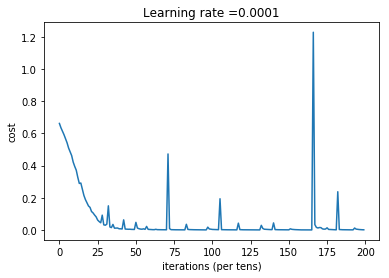

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.592


In [20]:
parameters = model(X_train, Y_train, X_test, Y_test)

## 8 - Test with your own image

We can now take a picture of our cat or dog and see the output of our model. To do that:

In [31]:
#test_image = "cat.jpg"
test_image = "dog.jpg"
my_image = read_image(test_image).reshape(1, ROWS*COLS*CHANNELS).T
X = my_image / 255.
#print(X.shape)

Bellow we use predict function to predict Cat vs Dog from our X image:

In [22]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [X.shape[0], 1])
    
    z3 = forward_propagation(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return str(np.squeeze(prediction))

In [25]:
predict(X, parameters)

'0'

## 9 - Restore the graph from .meta file

When we save the variables, it creates a .meta file. This file contains the graph structure. Therefore, we can import the meta graph `using tf.train.import_meta_graph()` and restore the values of the graph. Let's import the graph and print all tensors in the graph:

In [26]:
# delete the current graph
tf.reset_default_graph()

# import the graph from the file
imported_graph = tf.train.import_meta_graph('TensorFlow-first-network.meta')

# list all the tensors in the graph
for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

X
Y
W1/Initializer/random_uniform/shape
W1/Initializer/random_uniform/min
W1/Initializer/random_uniform/max
W1/Initializer/random_uniform/RandomUniform
W1/Initializer/random_uniform/sub
W1/Initializer/random_uniform/mul
W1/Initializer/random_uniform
W1
W1/Assign
W1/read
b1/Initializer/zeros
b1
b1/Assign
b1/read
W2/Initializer/random_uniform/shape
W2/Initializer/random_uniform/min
W2/Initializer/random_uniform/max
W2/Initializer/random_uniform/RandomUniform
W2/Initializer/random_uniform/sub
W2/Initializer/random_uniform/mul
W2/Initializer/random_uniform
W2
W2/Assign
W2/read
b2/Initializer/zeros
b2
b2/Assign
b2/read
W3/Initializer/random_uniform/shape
W3/Initializer/random_uniform/min
W3/Initializer/random_uniform/max
W3/Initializer/random_uniform/RandomUniform
W3/Initializer/random_uniform/sub
W3/Initializer/random_uniform/mul
W3/Initializer/random_uniform
W3
W3/Assign
W3/read
b3/Initializer/zeros
b3
b3/Assign
b3/read
MatMul
Add
Relu
MatMul_1
Add_1
Relu_1
MatMul_2
Add_2
transpose/perm
t

`tf.train.Saver()` saves the variables with the TensorFlow name. Now that we have the imported graph, we know that we are interested in W1, W2, W3 and b1, b2, b3 tensors, we can restore them from parameters:

In [28]:
tf.reset_default_graph()
with tf.Session() as sess:

    ## Load the entire model previuosly saved in a checkpoint
    the_Saver = tf.train.import_meta_graph('TensorFlow-first-network' + '.meta')
    the_Saver.restore(sess, './TensorFlow-first-network')

    W1,b1,W2,b2,W3,b3 = sess.run(['W1:0', 'b1:0','W2:0','b2:0', 'W3:0','b3:0'])
    parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    #print("W1 = ", parameters["W1"])
    #print("b1 = ", parameters["b1"])
    #print("W2 = ", parameters["W2"])
    #print("b2 = ", parameters["b2"])
    #print("W3 = ", parameters["W3"])
    #print("b3 = ", parameters["b3"])

INFO:tensorflow:Restoring parameters from ./TensorFlow-first-network


Try again:

In [32]:
predict(X, parameters)

'1'